# Plotting cross section ratios as a function of Bjorken-x

<h2 style="text-align: center; color: orange"> Script to probe delta correction methods </h2>

In [123]:
folder = 'deltacorr'

import uproot, sys
from time import time
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import stats
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat, datahist_from_array, mchist_from_array, cereff, baja, E, leaky_cauldron
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, He4_dict, He3_dict, C12_dict_l2, delta_correction
from common_functions import Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict, cafe_report_path, tinfo_path

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{Model}
\end{equation}

In [110]:
ntg = 'C12' # What is the nuclei in numerator?

In [111]:
leaky = 0 # 1 for leaky cauldron, 0 for regular
nsimstring = ntg.lower()
print("nsimstring", nsimstring)
dtg = 'LD2' # What is the nuclei in denominator?
dsimstring = dtg.lower()
print("dsimstring", dsimstring)
ald = 'Dummy' # Aluminium dummy target
dang = 20.0 # What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] # What are your desired central momenta (just the magnitude)
bin_per_mom = 32 # How many bins per momentum?
C = 0
bin_num = bin_per_mom * len(dmom) # Total number of bins in the combined histogram

# Kinematic variables
ts, idang = dang, int(dang) # Spectrometer angle
Z, A = target_info[ntg][0], target_info[ntg][1]  # Target
thick = target_info[ntg][2] # g/cm2. From Cameron's target sheet column 'R'
ep_min = {}
ep_max = {}

# Constants
Ei, Mp = 10.54, 0.93825 # Beam energcountsy and proton mass in GeV
N_A, Q_E = 6.02e+23, 1.60e-19 # Avogadro's number and charge in 1 electron
dpp_up, dpp_down = 10.0, -10.0 # Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))

for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 100.0, -100.0, 65.0, -65.0 # mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
    sim_charge = 1.
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

nsimstring c12
dsimstring ld2


<h1 align="center">DATA WORK FOR NTG</h1>

In [112]:
target_dict_name = f'{ntg}_dict'
# target_dict_name = f'{ntg}_dict_l2' # To read ladder 2 carbon runs
target_dict = globals()[target_dict_name]
delta_hist = {}
theta_dict = {}
track_hist = {}
eff_weight = {}
data_delta = np.linspace(-8.0, 8.0, bin_per_mom + 1)

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in target_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag', 'H_dc_ntrack']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1 )
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]

    # Cherenkov efficiency correction
    eff_weight[momentum] = 1 / cereff(dp_cut)

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)

Mean scaling factor for C12 at 2.42 GeV/c is 0.00017111555960878526
Total scaling factor for C12 at 2.42 GeV/c is 11688.007826830715
Scaling factor for C12 at 2.42 GeV/c is 8.555777980439263e-05
Counts for C12 at 2.42 GeV is 11584.950970582458
Mean scaling factor for C12 at 2.71 GeV/c is 0.00013381371810957993
Total scaling factor for C12 at 2.71 GeV/c is 14946.150725460016
Scaling factor for C12 at 2.71 GeV/c is 6.690685905478996e-05
Counts for C12 at 2.71 GeV is 13787.27236341818
Mean scaling factor for C12 at 3.04 GeV/c is 7.80192596113818e-05
Total scaling factor for C12 at 3.04 GeV/c is 25634.695970739907
Scaling factor for C12 at 3.04 GeV/c is 3.90096298056909e-05
Counts for C12 at 3.04 GeV is 21997.198318991603
Mean scaling factor for C12 at 3.4 GeV/c is 7.424755953954052e-05
Total scaling factor for C12 at 3.4 GeV/c is 26936.912302617842
Scaling factor for C12 at 3.4 GeV/c is 3.712377976977026e-05
Counts for C12 at 3.4 GeV is 21533.920352211528
Mean scaling factor for C12 at 3.

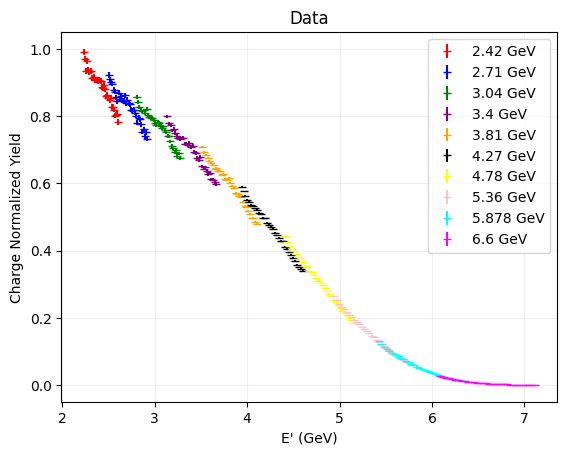

In [113]:
# Calculate the charge normalized yield and the uncertainty per bin
if ntg == 'He3' and leaky == 1:
    print("Analyzing leaky runs")
    delta_bin_contents_2p42_ntg, delta_bin_errors_2p42_ntg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg, eff_weight[2.42] / 1.0015)
    delta_bin_contents_2p71_ntg, delta_bin_errors_2p71_ntg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg, eff_weight[2.71] / 1.0537)
    delta_bin_contents_3p04_ntg, delta_bin_errors_3p04_ntg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg, eff_weight[3.04] / 1.0539)
    delta_bin_contents_3p4_ntg, delta_bin_errors_3p4_ntg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg, eff_weight[3.4] / 1.0818)
    delta_bin_contents_3p81_ntg, delta_bin_errors_3p81_ntg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg, eff_weight[3.81] / 1.0838)
    delta_bin_contents_4p27_ntg, delta_bin_errors_4p27_ntg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg, eff_weight[4.27] / 1.1104)
    delta_bin_contents_4p78_ntg, delta_bin_errors_4p78_ntg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg, eff_weight[4.78] / 1.1141)
    delta_bin_contents_5p36_ntg, delta_bin_errors_5p36_ntg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg, eff_weight[5.36] / 1.1810)
    delta_bin_contents_5p878_ntg, delta_bin_errors_5p878_ntg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg, eff_weight[5.878] / 1.18045)
    delta_bin_contents_6p6_ntg, delta_bin_errors_6p6_ntg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg, eff_weight[6.6] / 1.5401)
else:
    delta_bin_contents_2p42_ntg, delta_bin_errors_2p42_ntg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg, eff_weight[2.42])
    delta_bin_contents_2p71_ntg, delta_bin_errors_2p71_ntg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg, eff_weight[2.71])
    delta_bin_contents_3p04_ntg, delta_bin_errors_3p04_ntg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg, eff_weight[3.04])
    delta_bin_contents_3p4_ntg, delta_bin_errors_3p4_ntg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg, eff_weight[3.4])
    delta_bin_contents_3p81_ntg, delta_bin_errors_3p81_ntg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg, eff_weight[3.81])
    delta_bin_contents_4p27_ntg, delta_bin_errors_4p27_ntg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg, eff_weight[4.27])
    delta_bin_contents_4p78_ntg, delta_bin_errors_4p78_ntg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg, eff_weight[4.78])
    delta_bin_contents_5p36_ntg, delta_bin_errors_5p36_ntg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg, eff_weight[5.36])
    delta_bin_contents_5p878_ntg, delta_bin_errors_5p878_ntg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg, eff_weight[5.878])
    delta_bin_contents_6p6_ntg, delta_bin_errors_6p6_ntg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg, eff_weight[6.6])

_, delta_bin_edges_2p42 = np.histogram(delta_hist[2.42], bins = data_delta)
_, delta_bin_edges_2p71 = np.histogram(delta_hist[2.71], bins = data_delta)
_, delta_bin_edges_3p04 = np.histogram(delta_hist[3.04], bins = data_delta)
_, delta_bin_edges_3p4 = np.histogram(delta_hist[3.4], bins = data_delta)
_, delta_bin_edges_3p81 = np.histogram(delta_hist[3.81], bins = data_delta)
_, delta_bin_edges_4p27 = np.histogram(delta_hist[4.27], bins = data_delta)
_, delta_bin_edges_4p78 = np.histogram(delta_hist[4.78], bins = data_delta)
_, delta_bin_edges_5p36 = np.histogram(delta_hist[5.36], bins = data_delta)
_, delta_bin_edges_5p878 = np.histogram(delta_hist[5.878], bins = data_delta)
_, delta_bin_edges_6p6 = np.histogram(delta_hist[6.6], bins = data_delta)

delta_bin_centers_2p42 = (delta_bin_edges_2p42[:-1] + delta_bin_edges_2p42[1:]) / 2
delta_bin_centers_2p71 = (delta_bin_edges_2p71[:-1] + delta_bin_edges_2p71[1:]) / 2
delta_bin_centers_3p04 = (delta_bin_edges_3p04[:-1] + delta_bin_edges_3p04[1:]) / 2
delta_bin_centers_3p4 = (delta_bin_edges_3p4[:-1] + delta_bin_edges_3p4[1:]) / 2
delta_bin_centers_3p81 = (delta_bin_edges_3p81[:-1] + delta_bin_edges_3p81[1:]) / 2
delta_bin_centers_4p27 = (delta_bin_edges_4p27[:-1] + delta_bin_edges_4p27[1:]) / 2
delta_bin_centers_4p78 = (delta_bin_edges_4p78[:-1] + delta_bin_edges_4p78[1:]) / 2
delta_bin_centers_5p36 = (delta_bin_edges_5p36[:-1] + delta_bin_edges_5p36[1:]) / 2
delta_bin_centers_5p878 = (delta_bin_edges_5p878[:-1] + delta_bin_edges_5p878[1:]) / 2
delta_bin_centers_6p6 = (delta_bin_edges_6p6[:-1] + delta_bin_edges_6p6[1:]) / 2

binned_eprime_bin_centers_2p42 = 2.42 * (1 + 0.01 * delta_bin_centers_2p42)
binned_eprime_bin_centers_2p71 = 2.71 * (1 + 0.01 * delta_bin_centers_2p71)
binned_eprime_bin_centers_3p04 = 3.04 * (1 + 0.01 * delta_bin_centers_3p04)
binned_eprime_bin_centers_3p4 = 3.4 * (1 + 0.01 * delta_bin_centers_3p4)
binned_eprime_bin_centers_3p81 = 3.81 * (1 + 0.01 * delta_bin_centers_3p81)
binned_eprime_bin_centers_4p27 = 4.27 * (1 + 0.01 * delta_bin_centers_4p27)
binned_eprime_bin_centers_4p78 = 4.78 * (1 + 0.01 * delta_bin_centers_4p78)
binned_eprime_bin_centers_5p36 = 5.36 * (1 + 0.01 * delta_bin_centers_5p36)
binned_eprime_bin_centers_5p878 = 5.878 * (1 + 0.01 * delta_bin_centers_5p878)
binned_eprime_bin_centers_6p6 = 6.6 * (1 + 0.01 * delta_bin_centers_6p6)

# Calculate the charge symmetric background fraction per bin
csb_frac_2p42_ntg = csb(binned_eprime_bin_centers_2p42, ntg, dang)
csb_frac_2p71_ntg = csb(binned_eprime_bin_centers_2p71, ntg, dang)
csb_frac_3p04_ntg = csb(binned_eprime_bin_centers_3p04, ntg, dang)
csb_frac_3p4_ntg = csb(binned_eprime_bin_centers_3p4, ntg, dang)
csb_frac_3p81_ntg = csb(binned_eprime_bin_centers_3p81, ntg, dang)
csb_frac_4p27_ntg = csb(binned_eprime_bin_centers_4p27, ntg, dang)
csb_frac_4p78_ntg = csb(binned_eprime_bin_centers_4p78, ntg, dang)
csb_frac_5p36_ntg = csb(binned_eprime_bin_centers_5p36, ntg, dang)
csb_frac_5p878_ntg = csb(binned_eprime_bin_centers_5p878, ntg, dang)
csb_frac_6p6_ntg = csb(binned_eprime_bin_centers_6p6, ntg, dang)

# Subtract the charge symmetric background fraction from the total yield
subtracted_csb_contents_2p42_ntg = delta_bin_contents_2p42_ntg * (1 - csb_frac_2p42_ntg)
subtracted_csb_contents_2p71_ntg = delta_bin_contents_2p71_ntg * (1 - csb_frac_2p71_ntg)
subtracted_csb_contents_3p04_ntg = delta_bin_contents_3p04_ntg * (1 - csb_frac_3p04_ntg)
subtracted_csb_contents_3p4_ntg = delta_bin_contents_3p4_ntg * (1 - csb_frac_3p4_ntg)
subtracted_csb_contents_3p81_ntg = delta_bin_contents_3p81_ntg * (1 - csb_frac_3p81_ntg)
subtracted_csb_contents_4p27_ntg = delta_bin_contents_4p27_ntg * (1 - csb_frac_4p27_ntg)
subtracted_csb_contents_4p78_ntg = delta_bin_contents_4p78_ntg * (1 - csb_frac_4p78_ntg)
subtracted_csb_contents_5p36_ntg = delta_bin_contents_5p36_ntg * (1 - csb_frac_5p36_ntg)
subtracted_csb_contents_5p878_ntg = delta_bin_contents_5p878_ntg * (1 - csb_frac_5p878_ntg)
subtracted_csb_contents_6p6_ntg = delta_bin_contents_6p6_ntg * (1 - csb_frac_6p6_ntg)

# Add the errors in quadrature
subtracted_csb_errors_2p42_ntg = delta_bin_errors_2p42_ntg * (1 - csb_frac_2p42_ntg)
subtracted_csb_errors_2p71_ntg = delta_bin_errors_2p71_ntg * (1 - csb_frac_2p71_ntg)
subtracted_csb_errors_3p04_ntg = delta_bin_errors_3p04_ntg * (1 - csb_frac_3p04_ntg)
subtracted_csb_errors_3p4_ntg = delta_bin_errors_3p4_ntg * (1 - csb_frac_3p4_ntg)
subtracted_csb_errors_3p81_ntg = delta_bin_errors_3p81_ntg * (1 - csb_frac_3p81_ntg)
subtracted_csb_errors_4p27_ntg = delta_bin_errors_4p27_ntg * (1 - csb_frac_4p27_ntg)
subtracted_csb_errors_4p78_ntg = delta_bin_errors_4p78_ntg * (1 - csb_frac_4p78_ntg)
subtracted_csb_errors_5p36_ntg = delta_bin_errors_5p36_ntg * (1 - csb_frac_5p36_ntg)
subtracted_csb_errors_5p878_ntg = delta_bin_errors_5p878_ntg * (1 - csb_frac_5p878_ntg)
subtracted_csb_errors_6p6_ntg = delta_bin_errors_6p6_ntg * (1 - csb_frac_6p6_ntg)

# fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
ax.errorbar(binned_eprime_bin_centers_2p42, delta_bin_contents_2p42_ntg, yerr = delta_bin_errors_2p42_ntg, fmt = '_', color = 'red', label = '2.42 GeV')
ax.errorbar(binned_eprime_bin_centers_2p71, delta_bin_contents_2p71_ntg, yerr = delta_bin_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax.errorbar(binned_eprime_bin_centers_3p04, delta_bin_contents_3p04_ntg, yerr = delta_bin_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
ax.errorbar(binned_eprime_bin_centers_3p4, delta_bin_contents_3p4_ntg, yerr = delta_bin_errors_3p4_ntg, fmt = '_', color = 'purple', label = '3.4 GeV')
ax.errorbar(binned_eprime_bin_centers_3p81, delta_bin_contents_3p81_ntg, yerr = delta_bin_errors_3p81_ntg, fmt = '_', color = 'orange', label = '3.81 GeV')
ax.errorbar(binned_eprime_bin_centers_4p27, delta_bin_contents_4p27_ntg, yerr = delta_bin_errors_4p27_ntg, fmt = '_', color = 'black', label = '4.27 GeV')
ax.errorbar(binned_eprime_bin_centers_4p78, delta_bin_contents_4p78_ntg, yerr = delta_bin_errors_4p78_ntg, fmt = '_', color = 'yellow', label = '4.78 GeV')
ax.errorbar(binned_eprime_bin_centers_5p36, delta_bin_contents_5p36_ntg, yerr = delta_bin_errors_5p36_ntg, fmt = '_', color = 'pink', label = '5.36 GeV')
ax.errorbar(binned_eprime_bin_centers_5p878, delta_bin_contents_5p878_ntg, yerr = delta_bin_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
ax.errorbar(binned_eprime_bin_centers_6p6, delta_bin_contents_6p6_ntg, yerr = delta_bin_errors_6p6_ntg, fmt = '_', color = 'magenta', label = '6.6 GeV')
ax.set_ylabel('Charge Normalized Yield')
ax.set_xlabel('E\' (GeV)')
ax.set_title('Data')
ax.legend()
# ax.set_yscale('log')
ax.grid(alpha = 0.2)
# fig.savefig(f'{folder}/{nsimstring}_{dsimstring}_newyield.pdf')

<h1 align = 'center'> TARGET SPECIFIC DATA YIELD CORRECTION</h1>

In [114]:
if ntg == 'Ca48':
    print("Correcting for Ca40 contamination in Ca48 target")
    C = 0.113 # Ratio of Ca40 contamination in Ca48 target to Ca40 target
    cont_tg = 'Ca40'

elif ntg == 'B10':
    print("Correcting for C12 contamination in B10 target")
    C = 0.231 # Ratio of C12 contamination in B10 target to C12 target
    cont_tg = 'C12'

elif ntg == 'B11':
    print("Correcting for C12 contamination in B11 target")
    C = 0.236 # Ratio of C12 contamination in B11 target to C12 target
    cont_tg = 'C12'

elif ntg == 'He3' or ntg == 'LD2' or ntg == 'He4':
    print("Performing Aluminum cell wall subtraction")
    C = 0.2165 # Mean of Ratio of upstream & downstream dummy to target cell thickness
    cont_tg = ald
    
else:
    print("No contamination correction needed")
    C = 0

if C != 0:
    cont_dict_name = f'{cont_tg}_dict' # Dictionary containing the runs for the contaminant
    cont_dict = globals()[cont_dict_name]    
    for momentum in dmom:
        files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in cont_dict[momentum]]
        branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
        electrons = uproot.concatenate(files, branches)

        data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
        dp_cut = electrons['H_gtr_dp'][data_cut]
        theta_cut = electrons['H_gtr_th'][data_cut]
        phi_cut = electrons['H_gtr_ph'][data_cut]

        eff_weight[momentum] = 1 / cereff(dp_cut) # Cherenkov efficiency correction

        theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
        delta_hist[momentum] = np.array(dp_cut)

    # Get yield and yield error from array
    contaminant_eprime_bin_contents_2p42, contaminant_eprime_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, data_delta, cont_tg, eff_weight[2.42])
    contaminant_eprime_bin_contents_2p71, contaminant_eprime_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, data_delta, cont_tg, eff_weight[2.71])
    contaminant_eprime_bin_contents_3p04, contaminant_eprime_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, data_delta, cont_tg, eff_weight[3.04])
    contaminant_eprime_bin_contents_3p4, contaminant_eprime_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, data_delta, cont_tg, eff_weight[3.4])
    contaminant_eprime_bin_contents_3p81, contaminant_eprime_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, data_delta, cont_tg, eff_weight[3.81])
    contaminant_eprime_bin_contents_4p27, contaminant_eprime_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, data_delta, cont_tg, eff_weight[4.27])
    contaminant_eprime_bin_contents_4p78, contaminant_eprime_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, data_delta, cont_tg, eff_weight[4.78])
    contaminant_eprime_bin_contents_5p36, contaminant_eprime_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, data_delta, cont_tg, eff_weight[5.36])
    contaminant_eprime_bin_contents_5p878, contaminant_eprime_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, data_delta, cont_tg, eff_weight[5.878])
    contaminant_eprime_bin_contents_6p6, contaminant_eprime_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, data_delta, cont_tg, eff_weight[6.6])

    # Calculate the charge symmetric background fraction per bin for contaminant
    csb_frac_2p42_cont = csb(binned_eprime_bin_centers_2p42, cont_tg, dang)
    csb_frac_2p71_cont = csb(binned_eprime_bin_centers_2p71, cont_tg, dang)
    csb_frac_3p04_cont = csb(binned_eprime_bin_centers_3p04, cont_tg, dang)
    csb_frac_3p4_cont = csb(binned_eprime_bin_centers_3p4, cont_tg, dang)
    csb_frac_3p81_cont = csb(binned_eprime_bin_centers_3p81, cont_tg, dang)
    csb_frac_4p27_cont = csb(binned_eprime_bin_centers_4p27, cont_tg, dang)
    csb_frac_4p78_cont = csb(binned_eprime_bin_centers_4p78, cont_tg, dang)
    csb_frac_5p36_cont = csb(binned_eprime_bin_centers_5p36, cont_tg, dang)
    csb_frac_5p878_cont = csb(binned_eprime_bin_centers_5p878, cont_tg, dang)
    csb_frac_6p6_cont = csb(binned_eprime_bin_centers_6p6, cont_tg, dang)

    # Error propagation
    contaminant_eprime_bin_errors_2p42 = contaminant_eprime_bin_errors_2p42 * (1 - csb_frac_2p42_cont)
    contaminant_eprime_bin_errors_2p71 = contaminant_eprime_bin_errors_2p71 * (1 - csb_frac_2p71_cont)
    contaminant_eprime_bin_errors_3p04 = contaminant_eprime_bin_errors_3p04 * (1 - csb_frac_3p04_cont)
    contaminant_eprime_bin_errors_3p4 = contaminant_eprime_bin_errors_3p4 * (1 - csb_frac_3p4_cont)
    contaminant_eprime_bin_errors_3p81 = contaminant_eprime_bin_errors_3p81 * (1 - csb_frac_3p81_cont)
    contaminant_eprime_bin_errors_4p27 = contaminant_eprime_bin_errors_4p27 * (1 - csb_frac_4p27_cont)
    contaminant_eprime_bin_errors_4p78 = contaminant_eprime_bin_errors_4p78 * (1 - csb_frac_4p78_cont)
    contaminant_eprime_bin_errors_5p36 = contaminant_eprime_bin_errors_5p36 * (1 - csb_frac_5p36_cont)
    contaminant_eprime_bin_errors_5p878 = contaminant_eprime_bin_errors_5p878 * (1 - csb_frac_5p878_cont)
    contaminant_eprime_bin_errors_6p6 = contaminant_eprime_bin_errors_6p6 * (1 - csb_frac_6p6_cont)

    # Subtract CSB from the total yield of the contaminant
    subtracted_bin_contents_2p42_cont = contaminant_eprime_bin_contents_2p42 * (1 - csb_frac_2p42_cont)
    subtracted_bin_contents_2p71_cont = contaminant_eprime_bin_contents_2p71 * (1 - csb_frac_2p71_cont)
    subtracted_bin_contents_3p04_cont = contaminant_eprime_bin_contents_3p04 * (1 - csb_frac_3p04_cont)
    subtracted_bin_contents_3p4_cont = contaminant_eprime_bin_contents_3p4 * (1 - csb_frac_3p4_cont)
    subtracted_bin_contents_3p81_cont = contaminant_eprime_bin_contents_3p81 * (1 - csb_frac_3p81_cont)
    subtracted_bin_contents_4p27_cont = contaminant_eprime_bin_contents_4p27 * (1 - csb_frac_4p27_cont)
    subtracted_bin_contents_4p78_cont = contaminant_eprime_bin_contents_4p78 * (1 - csb_frac_4p78_cont)
    subtracted_bin_contents_5p36_cont = contaminant_eprime_bin_contents_5p36 * (1 - csb_frac_5p36_cont)
    subtracted_bin_contents_5p878_cont = contaminant_eprime_bin_contents_5p878 * (1 - csb_frac_5p878_cont)
    subtracted_bin_contents_6p6_cont = contaminant_eprime_bin_contents_6p6 * (1 - csb_frac_6p6_cont)

    # Perform Contamination Subtraction
    subtracted_bin_contents_2p42_ntg = subtracted_csb_contents_2p42_ntg - (C * subtracted_bin_contents_2p42_cont)
    subtracted_bin_contents_2p71_ntg = subtracted_csb_contents_2p71_ntg - (C * subtracted_bin_contents_2p71_cont)
    subtracted_bin_contents_3p04_ntg = subtracted_csb_contents_3p04_ntg - (C * subtracted_bin_contents_3p04_cont)
    subtracted_bin_contents_3p4_ntg = subtracted_csb_contents_3p4_ntg - (C * subtracted_bin_contents_3p4_cont)
    subtracted_bin_contents_3p81_ntg = subtracted_csb_contents_3p81_ntg - (C * subtracted_bin_contents_3p81_cont)
    subtracted_bin_contents_4p27_ntg = subtracted_csb_contents_4p27_ntg - (C * subtracted_bin_contents_4p27_cont)
    subtracted_bin_contents_4p78_ntg = subtracted_csb_contents_4p78_ntg - (C * subtracted_bin_contents_4p78_cont)
    subtracted_bin_contents_5p36_ntg = subtracted_csb_contents_5p36_ntg - (C * subtracted_bin_contents_5p36_cont)
    subtracted_bin_contents_5p878_ntg = subtracted_csb_contents_5p878_ntg - (C * subtracted_bin_contents_5p878_cont)
    subtracted_bin_contents_6p6_ntg = subtracted_csb_contents_6p6_ntg - (C * subtracted_bin_contents_6p6_cont)

    # Add the errors in quadrature
    subtracted_bin_errors_2p42_ntg = np.sqrt((subtracted_csb_errors_2p42_ntg)**2 + (C * contaminant_eprime_bin_errors_2p42)**2)
    subtracted_bin_errors_2p71_ntg = np.sqrt((subtracted_csb_errors_2p71_ntg)**2 + (C * contaminant_eprime_bin_errors_2p71)**2)
    subtracted_bin_errors_3p04_ntg = np.sqrt((subtracted_csb_errors_3p04_ntg)**2 + (C * contaminant_eprime_bin_errors_3p04)**2)
    subtracted_bin_errors_3p4_ntg = np.sqrt((subtracted_csb_errors_3p4_ntg)**2 + (C * contaminant_eprime_bin_errors_3p4)**2)
    subtracted_bin_errors_3p81_ntg = np.sqrt((subtracted_csb_errors_3p81_ntg)**2 + (C * contaminant_eprime_bin_errors_3p81)**2)
    subtracted_bin_errors_4p27_ntg = np.sqrt((subtracted_csb_errors_4p27_ntg)**2 + (C * contaminant_eprime_bin_errors_4p27)**2)
    subtracted_bin_errors_4p78_ntg = np.sqrt((subtracted_csb_errors_4p78_ntg)**2 + (C * contaminant_eprime_bin_errors_4p78)**2)
    subtracted_bin_errors_5p36_ntg = np.sqrt((subtracted_csb_errors_5p36_ntg)**2 + (C * contaminant_eprime_bin_errors_5p36)**2)
    subtracted_bin_errors_5p878_ntg = np.sqrt((subtracted_csb_errors_5p878_ntg)**2 + (C * contaminant_eprime_bin_errors_5p878)**2)
    subtracted_bin_errors_6p6_ntg = np.sqrt((subtracted_csb_errors_6p6_ntg)**2 + (C * contaminant_eprime_bin_errors_6p6)**2)

    fig, ax = plt.subplots()
    ax.errorbar(binned_eprime_bin_centers_2p42, subtracted_bin_contents_2p42_ntg, yerr = subtracted_bin_errors_2p42_ntg, fmt = '_', color = 'red', label = '2.42 GeV') 
    ax.errorbar(binned_eprime_bin_centers_2p71, subtracted_bin_contents_2p71_ntg, yerr = subtracted_bin_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p04, subtracted_bin_contents_3p04_ntg, yerr = subtracted_bin_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p4, subtracted_bin_contents_3p4_ntg, yerr = subtracted_bin_errors_3p4_ntg, fmt = '_', color = 'orange', label = '3.4 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p81, subtracted_bin_contents_3p81_ntg, yerr = subtracted_bin_errors_3p81_ntg, fmt = '_', color = 'purple', label = '3.81 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p27, subtracted_bin_contents_4p27_ntg, yerr = subtracted_bin_errors_4p27_ntg, fmt = '_', color = 'yellow', label = '4.27 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p78, subtracted_bin_contents_4p78_ntg, yerr = subtracted_bin_errors_4p78_ntg, fmt = '_', color = 'pink', label = '4.78 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p36, subtracted_bin_contents_5p36_ntg, yerr = subtracted_bin_errors_5p36_ntg, fmt = '_', color = 'brown', label = '5.36 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p878, subtracted_bin_contents_5p878_ntg, yerr = subtracted_bin_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
    ax.errorbar(binned_eprime_bin_centers_6p6, subtracted_bin_contents_6p6_ntg, yerr = subtracted_bin_errors_6p6_ntg, fmt = '_', color = 'limegreen', label = '6.6 GeV')
    ax.set_xlabel('E\' (GeV)')
    ax.set_ylabel('Charge Normalized Yield')
    ax.set_title('Data-Contamination Subtracted')
    ax.grid(alpha = 0.2)
    # ax.set_yscale('log')
    # fig.savefig(f'{folder}/plots/contamination_subtraction_yield_{ntg}_{time.time():.0f}.pdf')

No contamination correction needed


<h2 align = 'center'> Make your choice for delta correction </h2>

In [124]:
method_input = input("Select a method for the delta correction:\n1. Weighting MC\n2. Changing delta\n3. No correction").strip()
if method_input == '1':
    method = 'weighting MC'
elif method_input == '2':
    method = 'changing delta'
elif method_input == '3':
    method = 'no correction'
else:
    sys.exit('Invalid input. Please enter 1, 2, or 3.')
    
print(f"You have selected {method} for the delta correction")

You have selected weighting MC for the delta correction


<h1 align="center">SIMULATION WORK FOR NTG</h1>


In [125]:
# Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/{xsec_tables}/xem2_emc_rc_{nsimstring}22_hms.out")

Eprime_dict = {}
delta_dict = {}
xsec_array = {}
mc_scale = {}
thetadict = {}
ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
delta_weight = {}
idang = int(dang)

for momentum in dmom:
        mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')

        # New MC files
        filepath = f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{nsimstring}.root"

        # Open the file and tree
        file = uproot.open(filepath)
        tree = file["h10"]

        # Load the branches
        electrons = tree.arrays(["hsdeltai", "hsytar", "hsyptari", "hsxptari", "stop_id"], library = 'np')    
        nentries = len(electrons["hsdeltai"])

        # Apply the delta correction before applying the cuts
        if method == 'changing delta':
                electrons["hsdeltai"] = (0.990337 * electrons["hsdeltai"]) - 0.00236077 * (electrons["hsdeltai"]**2) + 0.000286814 * (electrons["hsdeltai"]**3) + 2.09878E-6 * (electrons["hsdeltai"]**4) - 2.48674E-6 * (electrons["hsdeltai"]**5) + 1.8646E-7 * (electrons["hsdeltai"]**6) # According to Cameron's log entry

        # Apply the cuts
        mc_cut = (np.abs(electrons["hsdeltai"]) <= 8) & \
                (np.abs(electrons["hsyptari"]) < 0.032) & \
                (np.abs(electrons["hsxptari"]) < 0.085) & \
                (electrons["stop_id"] == 0)

        # Filter 'hsdelta' with the cuts
        hsdelta_cut = electrons["hsdeltai"][mc_cut]
        hsyptar_cut = electrons["hsyptari"][mc_cut]
        hsxptar_cut = electrons["hsxptari"][mc_cut]
        hsytar_cut = electrons["hsytar"][mc_cut]

        if method == 'weighting MC':
                delta_weight[momentum] = delta_correction(hsdelta_cut) # Dave's delta correction
        elif method == 'changing delta':
                delta_weight[momentum] = 1 # Delta correction already applied. No need to apply it as a weight
        elif method == 'no correction':
                delta_weight[momentum] = 1 # Dindoo muffin
        else:
                sys.exit("Invalid method. Please choose a valid method.")

        delta_dict[momentum] = hsdelta_cut

        # Calculate E' and theta (in degrees)
        Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
        thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
        thetadeg = np.rad2deg(thetarad)

        # Calculate the ytar acceptance correction factor
        ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021

        # MC Jacobian
        jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), -1.5)

        # Perform the interpolation
        points_ntg = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
        points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
        xsec_array[momentum] = griddata(points_ntg, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
        mc_scale[momentum] = (lumin * domega * (ep_max[momentum] - ep_min[momentum])) / nentries         # Calculate the scale for simulation

Should be -8 and +8 -7.999982796143737 7.999997124541551


Text(0.5, 1.0, 'C12@20˚ Simulation')

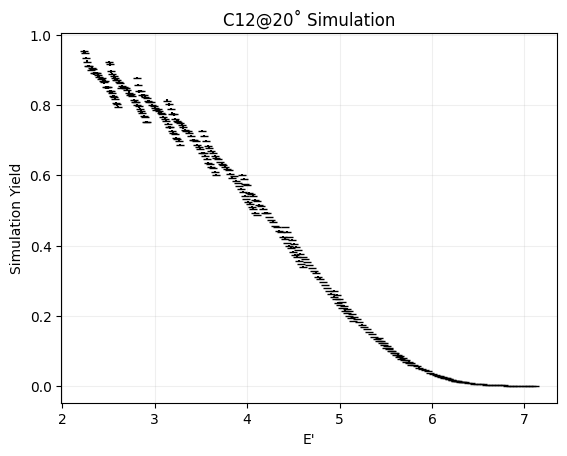

In [126]:
hsdelta_min, hsdelta_max = np.min(delta_dict[2.42]), np.max(delta_dict[2.42])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, bin_per_mom + 1)

# This function returns 2 arrays: bin counts (the counts in each bin taking weights into account) and bin edges (the edges of the bins)
bin_edges_delta_2p42 = np.histogram(delta_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hsdelta_binedges)[1]
bin_edges_delta_2p71 = np.histogram(delta_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hsdelta_binedges)[1]
bin_edges_delta_3p04 = np.histogram(delta_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hsdelta_binedges)[1]
bin_edges_delta_3p4 = np.histogram(delta_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hsdelta_binedges)[1]
bin_edges_delta_3p81 = np.histogram(delta_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hsdelta_binedges)[1]
bin_edges_delta_4p27 = np.histogram(delta_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hsdelta_binedges)[1]
bin_edges_delta_4p78 = np.histogram(delta_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hsdelta_binedges)[1]
bin_edges_delta_5p36 = np.histogram(delta_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hsdelta_binedges)[1]
bin_edges_delta_5p878 = np.histogram(delta_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hsdelta_binedges)[1]
bin_edges_delta_6p6 = np.histogram(delta_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hsdelta_binedges)[1]

# Gets the yield and yield error
bin_counts_eprime_2p42_mc_ntg, bin_errors_eprime_2p42_mc_ntg = mchist_from_array(delta_dict[2.42], xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42] * jacobian_weight[2.42] * delta_weight[2.42], hsdelta_binedges)
bin_counts_eprime_2p71_mc_ntg, bin_errors_eprime_2p71_mc_ntg = mchist_from_array(delta_dict[2.71], xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71] * jacobian_weight[2.71] * delta_weight[2.71], hsdelta_binedges)
bin_counts_eprime_3p04_mc_ntg, bin_errors_eprime_3p04_mc_ntg = mchist_from_array(delta_dict[3.04], xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04] * jacobian_weight[3.04] * delta_weight[3.04], hsdelta_binedges)
bin_counts_eprime_3p4_mc_ntg, bin_errors_eprime_3p4_mc_ntg = mchist_from_array(delta_dict[3.4], xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4] * jacobian_weight[3.4] * delta_weight[3.4], hsdelta_binedges)
bin_counts_eprime_3p81_mc_ntg, bin_errors_eprime_3p81_mc_ntg = mchist_from_array(delta_dict[3.81], xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81] * jacobian_weight[3.81] * delta_weight[3.81], hsdelta_binedges)
bin_counts_eprime_4p27_mc_ntg, bin_errors_eprime_4p27_mc_ntg = mchist_from_array(delta_dict[4.27], xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27] * jacobian_weight[4.27] * delta_weight[4.27], hsdelta_binedges)
bin_counts_eprime_4p78_mc_ntg, bin_errors_eprime_4p78_mc_ntg = mchist_from_array(delta_dict[4.78], xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78] * jacobian_weight[4.78] * delta_weight[4.78], hsdelta_binedges)
bin_counts_eprime_5p36_mc_ntg, bin_errors_eprime_5p36_mc_ntg = mchist_from_array(delta_dict[5.36], xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36] * jacobian_weight[5.36] * delta_weight[5.36], hsdelta_binedges)
bin_counts_eprime_5p878_mc_ntg, bin_errors_eprime_5p878_mc_ntg = mchist_from_array(delta_dict[5.878], xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878] * jacobian_weight[5.878] * delta_weight[5.878], hsdelta_binedges)
bin_counts_eprime_6p6_mc_ntg, bin_errors_eprime_6p6_mc_ntg = mchist_from_array(delta_dict[6.6], xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6] * jacobian_weight[6.6] * delta_weight[6.6], hsdelta_binedges)

bin_centers_delta_2p42 = (bin_edges_delta_2p42[:-1] + bin_edges_delta_2p42[1:]) / 2
bin_centers_delta_2p71 = (bin_edges_delta_2p71[:-1] + bin_edges_delta_2p71[1:]) / 2
bin_centers_delta_3p04 = (bin_edges_delta_3p04[:-1] + bin_edges_delta_3p04[1:]) / 2
bin_centers_delta_3p4 = (bin_edges_delta_3p4[:-1] + bin_edges_delta_3p4[1:]) / 2
bin_centers_delta_3p81 = (bin_edges_delta_3p81[:-1] + bin_edges_delta_3p81[1:]) / 2
bin_centers_delta_4p27 = (bin_edges_delta_4p27[:-1] + bin_edges_delta_4p27[1:]) / 2
bin_centers_delta_4p78 = (bin_edges_delta_4p78[:-1] + bin_edges_delta_4p78[1:]) / 2
bin_centers_delta_5p36 = (bin_edges_delta_5p36[:-1] + bin_edges_delta_5p36[1:]) / 2
bin_centers_delta_5p878 = (bin_edges_delta_5p878[:-1] + bin_edges_delta_5p878[1:]) / 2
bin_centers_delta_6p6 = (bin_edges_delta_6p6[:-1] + bin_edges_delta_6p6[1:]) / 2

binned_eprime_bin_centers_2p42_mc_ntg = 2.42 * (1 + 0.01 * bin_centers_delta_2p42)
binned_eprime_bin_centers_2p71_mc_ntg = 2.71 * (1 + 0.01 * bin_centers_delta_2p71)
binned_eprime_bin_centers_3p04_mc_ntg = 3.04 * (1 + 0.01 * bin_centers_delta_3p04)
binned_eprime_bin_centers_3p4_mc_ntg = 3.4 * (1 + 0.01 * bin_centers_delta_3p4)
binned_eprime_bin_centers_3p81_mc_ntg = 3.81 * (1 + 0.01 * bin_centers_delta_3p81)
binned_eprime_bin_centers_4p27_mc_ntg = 4.27 * (1 + 0.01 * bin_centers_delta_4p27)
binned_eprime_bin_centers_4p78_mc_ntg = 4.78 * (1 + 0.01 * bin_centers_delta_4p78)
binned_eprime_bin_centers_5p36_mc_ntg = 5.36 * (1 + 0.01 * bin_centers_delta_5p36)
binned_eprime_bin_centers_5p878_mc_ntg = 5.878 * (1 + 0.01 * bin_centers_delta_5p878)
binned_eprime_bin_centers_6p6_mc_ntg = 6.6 * (1 + 0.01 * bin_centers_delta_6p6)

#Plotting the histogram with error bars
fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42_mc_ntg, bin_counts_eprime_2p42_mc_ntg, yerr = bin_errors_eprime_2p42_mc_ntg, fmt = '_', color = 'black', label = 'Sim 2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71_mc_ntg, bin_counts_eprime_2p71_mc_ntg, yerr = bin_errors_eprime_2p71_mc_ntg, fmt = '_', color = 'black', label = 'Sim 2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04_mc_ntg, bin_counts_eprime_3p04_mc_ntg, yerr = bin_errors_eprime_3p04_mc_ntg, fmt = '_', color = 'black', label = 'Sim 3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4_mc_ntg, bin_counts_eprime_3p4_mc_ntg, yerr = bin_errors_eprime_3p4_mc_ntg, fmt = '_', color = 'black', label = 'Sim 3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81_mc_ntg, bin_counts_eprime_3p81_mc_ntg, yerr = bin_errors_eprime_3p81_mc_ntg, fmt = '_', color = 'black', label = 'Sim 3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27_mc_ntg, bin_counts_eprime_4p27_mc_ntg, yerr = bin_errors_eprime_4p27_mc_ntg, fmt = '_', color = 'black', label = 'Sim 4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78_mc_ntg, bin_counts_eprime_4p78_mc_ntg, yerr = bin_errors_eprime_4p78_mc_ntg, fmt = '_', color = 'black', label = 'Sim 4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36_mc_ntg, bin_counts_eprime_5p36_mc_ntg, yerr = bin_errors_eprime_5p36_mc_ntg, fmt = '_', color = 'black', label = 'Sim 5.36 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p878_mc_ntg, bin_counts_eprime_5p878_mc_ntg, yerr = bin_errors_eprime_5p878_mc_ntg, fmt = '_', color = 'black', label = 'Sim 5.878 GeV')
ax2.errorbar(binned_eprime_bin_centers_6p6_mc_ntg, bin_counts_eprime_6p6_mc_ntg, yerr = bin_errors_eprime_6p6_mc_ntg, fmt = '_', color = 'black', label = 'Sim 6.6 GeV')
ax2.grid(alpha = 0.2)
ax2.set_xlabel('E\'')
ax2.set_ylabel('Simulation Yield')
# ax2.set_yscale('log')
# ax.legend() 
ax2.set_title(f'{ntg}@{idang}˚ Simulation')
# fig2.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')

In [127]:
if C == 0:
    subtracted_bin_contents_2p42_ntg = subtracted_csb_contents_2p42_ntg
    subtracted_bin_contents_2p71_ntg = subtracted_csb_contents_2p71_ntg
    subtracted_bin_contents_3p04_ntg = subtracted_csb_contents_3p04_ntg
    subtracted_bin_contents_3p4_ntg = subtracted_csb_contents_3p4_ntg
    subtracted_bin_contents_3p81_ntg = subtracted_csb_contents_3p81_ntg
    subtracted_bin_contents_4p27_ntg = subtracted_csb_contents_4p27_ntg
    subtracted_bin_contents_4p78_ntg = subtracted_csb_contents_4p78_ntg
    subtracted_bin_contents_5p36_ntg = subtracted_csb_contents_5p36_ntg
    subtracted_bin_contents_5p878_ntg = subtracted_csb_contents_5p878_ntg
    subtracted_bin_contents_6p6_ntg = subtracted_csb_contents_6p6_ntg

    subtracted_bin_errors_2p42_ntg = subtracted_csb_errors_2p42_ntg
    subtracted_bin_errors_2p71_ntg = subtracted_csb_errors_2p71_ntg
    subtracted_bin_errors_3p04_ntg = subtracted_csb_errors_3p04_ntg
    subtracted_bin_errors_3p4_ntg = subtracted_csb_errors_3p4_ntg
    subtracted_bin_errors_3p81_ntg = subtracted_csb_errors_3p81_ntg
    subtracted_bin_errors_4p27_ntg = subtracted_csb_errors_4p27_ntg
    subtracted_bin_errors_4p78_ntg = subtracted_csb_errors_4p78_ntg
    subtracted_bin_errors_5p36_ntg = subtracted_csb_errors_5p36_ntg
    subtracted_bin_errors_5p878_ntg = subtracted_csb_errors_5p878_ntg
    subtracted_bin_errors_6p6_ntg = subtracted_csb_errors_6p6_ntg

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


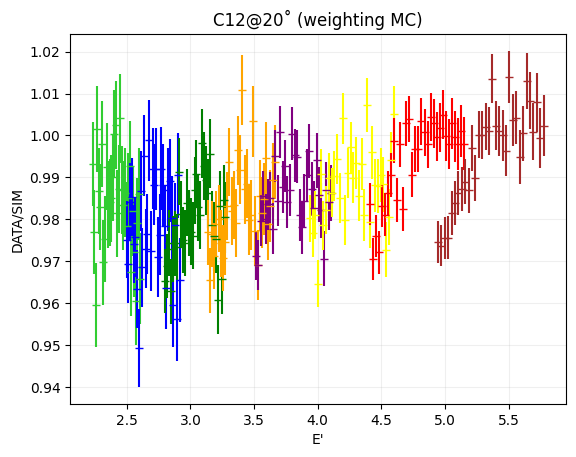

In [ ]:
ratio_eprime_2p42_ntg = subtracted_bin_contents_2p42_ntg / bin_counts_eprime_2p42_mc_ntg
ratio_eprime_2p71_ntg = subtracted_bin_contents_2p71_ntg / bin_counts_eprime_2p71_mc_ntg
ratio_eprime_3p04_ntg = subtracted_bin_contents_3p04_ntg / bin_counts_eprime_3p04_mc_ntg
ratio_eprime_3p4_ntg = subtracted_bin_contents_3p4_ntg / bin_counts_eprime_3p4_mc_ntg
ratio_eprime_3p81_ntg = subtracted_bin_contents_3p81_ntg / bin_counts_eprime_3p81_mc_ntg
ratio_eprime_4p27_ntg = subtracted_bin_contents_4p27_ntg / bin_counts_eprime_4p27_mc_ntg
ratio_eprime_4p78_ntg = subtracted_bin_contents_4p78_ntg / bin_counts_eprime_4p78_mc_ntg
ratio_eprime_5p36_ntg = subtracted_bin_contents_5p36_ntg / bin_counts_eprime_5p36_mc_ntg
ratio_eprime_5p878_ntg = subtracted_bin_contents_5p878_ntg / bin_counts_eprime_5p878_mc_ntg
ratio_eprime_6p6_ntg = subtracted_bin_contents_6p6_ntg / bin_counts_eprime_6p6_mc_ntg

# Add errors in quadrature. First is data and second is MC
ratio_errors_2p42_ntg = ratio_eprime_2p42_ntg * np.sqrt((subtracted_bin_errors_2p42_ntg / subtracted_bin_contents_2p42_ntg)**2 + (bin_errors_eprime_2p42_mc_ntg / bin_counts_eprime_2p42_mc_ntg)**2)
ratio_errors_2p71_ntg = ratio_eprime_2p71_ntg * np.sqrt((subtracted_bin_errors_2p71_ntg / subtracted_bin_contents_2p71_ntg)**2 + (bin_errors_eprime_2p71_mc_ntg / bin_counts_eprime_2p71_mc_ntg)**2)
ratio_errors_3p04_ntg = ratio_eprime_3p04_ntg * np.sqrt((subtracted_bin_errors_3p04_ntg / subtracted_bin_contents_3p04_ntg)**2 + (bin_errors_eprime_3p04_mc_ntg / bin_counts_eprime_3p04_mc_ntg)**2)
ratio_errors_3p4_ntg = ratio_eprime_3p4_ntg * np.sqrt((subtracted_bin_errors_3p4_ntg / subtracted_bin_contents_3p4_ntg)**2 + (bin_errors_eprime_3p4_mc_ntg / bin_counts_eprime_3p4_mc_ntg)**2)
ratio_errors_3p81_ntg = ratio_eprime_3p81_ntg * np.sqrt((subtracted_bin_errors_3p81_ntg / subtracted_bin_contents_3p81_ntg)**2 + (bin_errors_eprime_3p81_mc_ntg / bin_counts_eprime_3p81_mc_ntg)**2)
ratio_errors_4p27_ntg = ratio_eprime_4p27_ntg * np.sqrt((subtracted_bin_errors_4p27_ntg / subtracted_bin_contents_4p27_ntg)**2 + (bin_errors_eprime_4p27_mc_ntg / bin_counts_eprime_4p27_mc_ntg)**2)
ratio_errors_4p78_ntg = ratio_eprime_4p78_ntg * np.sqrt((subtracted_bin_errors_4p78_ntg / subtracted_bin_contents_4p78_ntg)**2 + (bin_errors_eprime_4p78_mc_ntg / bin_counts_eprime_4p78_mc_ntg)**2)
ratio_errors_5p36_ntg = ratio_eprime_5p36_ntg * np.sqrt((subtracted_bin_errors_5p36_ntg / subtracted_bin_contents_5p36_ntg)**2 + (bin_errors_eprime_5p36_mc_ntg / bin_counts_eprime_5p36_mc_ntg)**2)
ratio_errors_5p878_ntg = ratio_eprime_5p878_ntg * np.sqrt((subtracted_bin_errors_5p878_ntg / subtracted_bin_contents_5p878_ntg)**2 + (bin_errors_eprime_5p878_mc_ntg / bin_counts_eprime_5p878_mc_ntg)**2)
ratio_errors_6p6_ntg = ratio_eprime_6p6_ntg * np.sqrt((subtracted_bin_errors_6p6_ntg / subtracted_bin_contents_6p6_ntg)**2 + (bin_errors_eprime_6p6_mc_ntg / bin_counts_eprime_6p6_mc_ntg)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42, ratio_eprime_2p42_ntg, yerr = ratio_errors_2p42_ntg, fmt = '_', color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71, ratio_eprime_2p71_ntg, yerr = ratio_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04, ratio_eprime_3p04_ntg, yerr = ratio_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4, ratio_eprime_3p4_ntg, yerr = ratio_errors_3p4_ntg, fmt = '_', color = 'orange', label = '3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81, ratio_eprime_3p81_ntg, yerr = ratio_errors_3p81_ntg, fmt = '_', color = 'purple', label = '3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27, ratio_eprime_4p27_ntg, yerr = ratio_errors_4p27_ntg, fmt = '_', color = 'yellow', label = '4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78, ratio_eprime_4p78_ntg, yerr = ratio_errors_4p78_ntg, fmt = '_', color = 'red', label = '4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36, ratio_eprime_5p36_ntg, yerr = ratio_errors_5p36_ntg, fmt = '_', color = 'brown', label = '5.36 GeV')
# ax2.errorbar(binned_eprime_bin_centers_5p878, ratio_eprime_5p878_ntg, yerr = ratio_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
# ax2.errorbar(binned_eprime_bin_centers_6p6, ratio_eprime_6p6_ntg, yerr = ratio_errors_6p6_ntg, fmt = '_', color = 'lightgreen', label = '6.6 GeV')
ax2.set_xlabel('E\'')
ax2.set_ylabel('DATA/SIM')
ax2.set_title(f'{ntg}@{idang}˚ ({method})')
ax2.grid(alpha = 0.2)
# ax2.set_ylim(0.5, 1.1)
# fig2.savefig(f'{folder}/yieldratio_{ntg}_{idang}_{time():.0f}.png', dpi = 300)

In [131]:
eprime_bins = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
ratio_bins = np.concatenate((ratio_eprime_2p42_ntg, ratio_eprime_2p71_ntg, ratio_eprime_3p04_ntg, ratio_eprime_3p4_ntg, ratio_eprime_3p81_ntg, ratio_eprime_4p27_ntg, ratio_eprime_4p78_ntg, ratio_eprime_5p36_ntg, ratio_eprime_5p878_ntg, ratio_eprime_6p6_ntg))
ratio_errors = np.concatenate((ratio_errors_2p42_ntg, ratio_errors_2p71_ntg, ratio_errors_3p04_ntg, ratio_errors_3p4_ntg, ratio_errors_3p81_ntg, ratio_errors_4p27_ntg, ratio_errors_4p78_ntg, ratio_errors_5p36_ntg, ratio_errors_5p878_ntg, ratio_errors_6p6_ntg))
mc_yield = np.concatenate((bin_counts_eprime_2p42_mc_ntg, bin_counts_eprime_2p71_mc_ntg, bin_counts_eprime_3p04_mc_ntg, bin_counts_eprime_3p4_mc_ntg, bin_counts_eprime_3p81_mc_ntg, bin_counts_eprime_4p27_mc_ntg, bin_counts_eprime_4p78_mc_ntg, bin_counts_eprime_5p36_mc_ntg, bin_counts_eprime_5p878_mc_ntg, bin_counts_eprime_6p6_mc_ntg))
mc_errors = np.concatenate((bin_errors_eprime_2p42_mc_ntg, bin_errors_eprime_2p71_mc_ntg, bin_errors_eprime_3p04_mc_ntg, bin_errors_eprime_3p4_mc_ntg, bin_errors_eprime_3p81_mc_ntg, bin_errors_eprime_4p27_mc_ntg, bin_errors_eprime_4p78_mc_ntg, bin_errors_eprime_5p36_mc_ntg, bin_errors_eprime_5p878_mc_ntg, bin_errors_eprime_6p6_mc_ntg))
data_yield = np.concatenate((subtracted_bin_contents_2p42_ntg, subtracted_bin_contents_2p71_ntg, subtracted_bin_contents_3p04_ntg, subtracted_bin_contents_3p4_ntg, subtracted_bin_contents_3p81_ntg, subtracted_bin_contents_4p27_ntg, subtracted_bin_contents_4p78_ntg, subtracted_bin_contents_5p36_ntg, subtracted_bin_contents_5p878_ntg, subtracted_bin_contents_6p6_ntg))
data_errors = np.concatenate((subtracted_bin_errors_2p42_ntg, subtracted_bin_errors_2p71_ntg, subtracted_bin_errors_3p04_ntg, subtracted_bin_errors_3p4_ntg, subtracted_bin_errors_3p81_ntg, subtracted_bin_errors_4p27_ntg, subtracted_bin_errors_4p78_ntg, subtracted_bin_errors_5p36_ntg, subtracted_bin_errors_5p878_ntg, subtracted_bin_errors_6p6_ntg))

# with open(f'{folder}/yieldratio_{ntg}_{idang}.txt', 'w') as f:
#     for i in range(len(eprime_bins)):
#         f.write(f'{eprime_bins[i]} {ratio_bins[i]}\t{ratio_errors[i]}\n')

In [ ]:
with open(f'{folder}/{method}info{time():.0f}.py', 'w') as f:
    f.write(f"# {method} {ntg}@{idang}˚ \n")
    f.write(f"eprime_bins = {eprime_bins.tolist()}\n")
    f.write(f"ratio_bins = {ratio_bins.tolist()}\n")
    f.write(f"ratio_errors = {ratio_errors.tolist()}\n")
    f.write(f"mc_yield = {mc_yield.tolist()}\n")
    f.write(f"mc_errors = {mc_errors.tolist()}\n")
    f.write(f"data_yield = {data_yield.tolist()}\n")
    f.write(f"data_errors = {data_errors.tolist()}\n")

In [134]:
sys.path.append('/Users/AbSir/Desktop/Cross-Section/deltacorr')
from changing_deltainfo import mc_yield as mcycd
from weighting_MCinfo import mc_yield as mcyw8

320


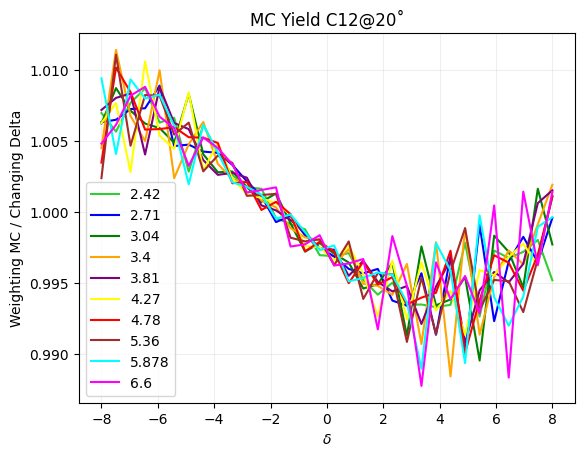

In [ ]:
ratio = np.array(mcyw8) / np.array(mcycd)
print(len(ratio))
ratio_2p42 = ratio[0:32]
ratio_2p71 = ratio[32:64]
ratio_3p04 = ratio[64:96]
ratio_3p4 = ratio[96:128]
ratio_3p81 = ratio[128:160]
ratio_4p27 = ratio[160:192]
ratio_4p78 = ratio[192:224]
ratio_5p36 = ratio[224:256]
ratio_5p878 = ratio[256:288]
ratio_6p6 = ratio[288:320]
delta = np.linspace(-8, 8, 32)
plt.plot(delta, ratio_2p42, label = '2.42', color = 'limegreen')
plt.plot(delta, ratio_2p71, label = '2.71', color = 'blue')
plt.plot(delta, ratio_3p04, label = '3.04', color = 'green')
plt.plot(delta, ratio_3p4, label = '3.4', color = 'orange')
plt.plot(delta, ratio_3p81, label = '3.81', color = 'purple')
plt.plot(delta, ratio_4p27, label = '4.27', color = 'yellow')
plt.plot(delta, ratio_4p78, label = '4.78', color = 'red')
plt.plot(delta, ratio_5p36, label = '5.36', color = 'brown')
plt.plot(delta, ratio_5p878, label = '5.878', color = 'cyan')
plt.plot(delta, ratio_6p6, label = '6.6', color = 'magenta')
plt.xlabel(r'$\delta$')
plt.ylabel('Weighting MC / Changing Delta')
plt.title(f'MC Yield {ntg}@{idang}˚')
plt.legend()
plt.grid(alpha = 0.2)
# plt.savefig(f'{folder}/MCyield_{ntg}_{idang}_{time():.0f}.png', dpi = 300)